In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


In [ ]:

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

metadata_path = '../data/balanced_data/normalized_metadata.csv'
normalization_params_path = '../data/balanced_data/normalization_params.json'
image_dir = '../data/balanced_data'
pretrained_conformer_path = './pretrained_models/conformer.pth'
pretrained_dnn_path = './pretrained_models/dnn.pth'
fusion_model_save_path = './conformer_e2e/saved_models_2STAR/best_model.pth'

with open(normalization_params_path, 'r') as f:
    normalization_params = json.load(f)

class FusionDataset(Dataset):
    def __init__(self, metadata_path, image_dir, normalization_params, transform=None):
        
        self.metadata = pd.read_csv(metadata_path)

        
        self.image_dir = image_dir
        self.transform = transform

        
        self.labels = self.metadata['target'].values.astype(int)

        
        
        columns_to_drop = [
            "isic_id", "target", "patient_id", "anatom_site_general", "image_type", 
            "tbp_tile_type", "attribution", "copyright_license", "lesion_id", "iddx_full", 
            "iddx_1", "iddx_2", "iddx_3", "iddx_4", "iddx_5", "mel_mitotic_index", 
            "mel_thick_mm", "tbp_lv_dnn_lesion_confidence"
        ]
        metadata_features = self.metadata.drop(columns=columns_to_drop, errors='ignore')


        
        for col, params in normalization_params.items():
            if col in metadata_features.columns:
                col_min = params['min']
                col_max = params['max']
                metadata_features[col] = (metadata_features[col] - col_min) / (col_max - col_min)

        self.metadata_features = metadata_features.values.astype(np.float32)

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        
        isic_id = self.metadata.iloc[idx]['isic_id']
        label = self.labels[idx]
        metadata_features = torch.tensor(self.metadata_features[idx], dtype=torch.float32)

        
        folder = '1' if label == 1 else '0'
        image_path = os.path.join(self.image_dir, folder, f"{isic_id}.jpg")
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, metadata_features, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

dataset = FusionDataset(metadata_path=metadata_path, image_dir=image_dir, normalization_params=normalization_params, transform=transform)


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")



class ConformerTinyBinary(nn.Module):
    def __init__(self, img_size=128, num_classes=2, embed_dim=256, num_heads=8, num_transformer_layers=3, dropout=0.2):
        super(ConformerTinyBinary, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout)
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_transformer_layers
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.conv(x)
        b, c, h, w = x.shape
        x = x.view(b, c, -1).permute(2, 0, 1)  
        x = self.transformer(x)
        x = x.mean(dim=0)  
        return x

class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

class FusionModel(nn.Module):
    def __init__(self, conformer, feedforward, conformer_embed_dim, feedforward_embed_dim, fusion_hidden_dim, output_dim=2, dropout_rate=0.0):
        super(FusionModel, self).__init__()
        self.conformer = conformer
        self.feedforward = feedforward

        
        self.fusion_fc = nn.Sequential(
            nn.Linear(conformer_embed_dim + feedforward_embed_dim, 2048),  
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(2048, 1024),  
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),  
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, output_dim)  
        )

    def forward(self, image, metadata):
        
        x = self.conformer.conv(image)
        b, c, h, w = x.shape
        x = x.view(b, c, -1).permute(2, 0, 1)  
        x = self.conformer.transformer(x)
        image_embed = x.mean(dim=0)  

        
        metadata_embed = self.feedforward.fc[:-1](metadata)  

        
        fusion_input = torch.cat((image_embed, metadata_embed), dim=1)
        output = self.fusion_fc(fusion_input)
        return output



conformer = ConformerTinyBinary(embed_dim=256).to(device)
feedforward = FeedforwardNN(input_dim=43, hidden_dim=128, output_dim=2).to(device)
fusion_model = FusionModel(
    conformer=conformer,
    feedforward=feedforward,
    conformer_embed_dim=256,
    feedforward_embed_dim=128,
    fusion_hidden_dim=1024,
    output_dim=2,
    dropout_rate=0.2
).to(device)


conformer.load_state_dict(torch.load(pretrained_conformer_path, map_location=device)['model_state_dict'])
feedforward.load_state_dict(torch.load(pretrained_dnn_path, map_location=device)['model_state_dict'])
fusion_model.load_state_dict(torch.load(fusion_model_save_path, map_location=device)['model_state_dict'])
fusion_model.eval()

Using device: cuda
Train size: 607, Validation size: 75, Test size: 77


c:\Users\jonec\miniconda3\envs\general_ai\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\jonec\AppData\Local\Temp\ipykernel_62296\2771933965.py:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no 

FusionModel(
  (conformer): ConformerTinyBinary(
    (conv): Sequential(
      (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout2d(p=0.2, inplace=False)
      (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout2d(p=0.2, inplace=False)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): Dropout2d(p=0.2, inplace=False)
    )
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256

## D

c:\Users\jonec\miniconda3\envs\general_ai\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Partial AUC (pAUC): 0.1460


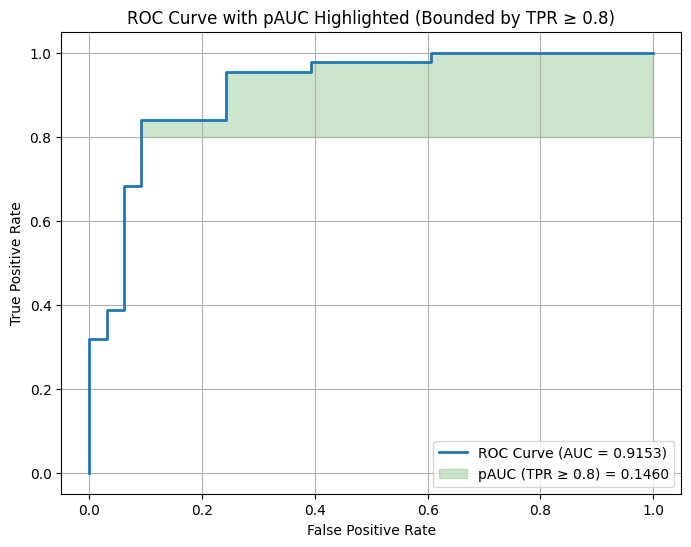

Corrected ROC Curve with pAUC saved at: ./roc_curve_with_pauc_corrected.png


In [ ]:

y_true, y_pred, y_pred_proba = [], [], []

with torch.no_grad():
    for image, metadata, labels in test_loader:
        image, metadata, labels = image.to(device), metadata.to(device), labels.to(device)
        outputs = fusion_model(image, metadata)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_proba.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())


def custom_metric(y_true, y_pred_proba, min_tpr=0.8):
    """
    Calculate the partial AUC (pAUC) based on a minimum TPR threshold.
    """
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)

    max_fpr = 1 - min_tpr
    v_gt = abs(y_true - 1)  
    v_pred = 1.0 - y_pred_proba  

    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (pauc_scaled - 0.5)

    return pauc

from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt


fpr, tpr, _ = roc_curve(y_true, y_pred_proba)


partial_auc = custom_metric(y_true, y_pred_proba, min_tpr=0.8)
print(f"Partial AUC (pAUC): {partial_auc:.4f}")


tpr_threshold = 0.8


valid_indices = tpr >= tpr_threshold


fpr_interp = np.interp(tpr_threshold, tpr, fpr)


fpr_bounded = np.concatenate(([fpr_interp], fpr[valid_indices]))
tpr_bounded = np.concatenate(([tpr_threshold], tpr[valid_indices]))


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_true, y_pred_proba):.4f})", linewidth=2)


plt.fill_between(
    fpr_bounded, 
    tpr_bounded, 
    tpr_threshold, 
    color="green", 
    alpha=0.2, 
    label=f"pAUC (TPR ≥ {tpr_threshold}) = {partial_auc:.4f}"
)


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with pAUC Highlighted (Bounded by TPR ≥ 0.8)")
plt.legend(loc="lower right")
plt.grid(True)


roc_curve_path = "./roc_curve_with_pauc_corrected.png"
plt.savefig(roc_curve_path, bbox_inches="tight")
plt.show()

print(f"Corrected ROC Curve with pAUC saved at: {roc_curve_path}")
